# Age and Gender Disparity in Hollywood
 
## Abstract
We have heard time and again that Hollywood is gender, age and minority biased. One topic covered in the media quite recently has been female actors being dramatically underpaid compared to their male counterparts. But, is this really true? On paper it makes sense that Hollywood would reflect broader society in underpaying one half of the population, yet does this also extend to age?  Perhaps there is real rational thinking behind bigger lips, face lifts and tummy tucks from aging stars.     

However, since not many of the actors in Hollywood (or their Agents) are willing to share their financial statements, there is little to no hard evidence to these claim, apart from the anecdotal type.  As we have been working with film financial data for some time, we wondered whether we can quantify these claims in any substantial way, backed by hard numbers.

Indeed, thousands of actors have graced the screen, albeit for just a moment, never to be seen again.  This is the nature of show biz after all.  Therefore, we focused our study on the creme de la creme - actors nominated for Academy Awards.  


## Caveats
Our analysis is limited to Oscar nominated actors / actresses, which represents the top tier of Hollywood actors.
- We only take into account Oscar nominations from 1980 to 2014.
- For each nominated actor/actress we consider all of their movies from 1995 with supported publically available financial information.
- All monetary figures are inflation adjusted.
- All data is publically available and will be updated over time where applicable.

If you are not fluent in python or statistics, you can ignore the code sprinkled in between and just focus on the text and accompanying graphs. Otherwise, feel free to download the data and code from https://github.com/vaultml/oscars

To begin, let us first load our data:

In [1]:
%pylab inline

import pandas as pd
import numpy as np
import data
from data import award
import streamgraph

plt.style.use('ggplot')

movies, genres = data.read_movies()
nominations = data.read_awards()
talents = data.read_talents()
roles = data.read_roles();

Populating the interactive namespace from numpy and matplotlib


We begin by flexing our muscles and first looking at the age distribution for nomiations.

In [5]:
def nomination_ages(awards=[award.best_actor], kinds=['W', 'N']):
    noms = nominations.query('award in ' + str(awards) + 'and kind in ' + str(kinds))
    data = []
    for row in noms.itertuples():
        talentid = row.talentid
        talent = talents.query('talentid == "{}"'.format(talentid))
        if len(talent) == 0:
            continue
        year = row.year
        birth_year = talent.iloc[0].birth_date.year
        data.append(year - birth_year)
        
    return data    

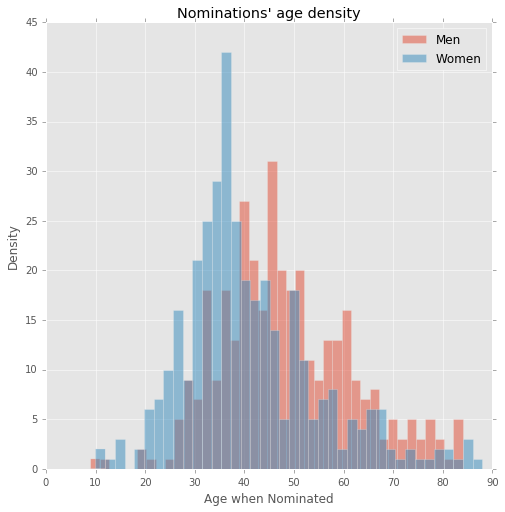

In [6]:
men = nomination_ages(awards=[award.best_actor, award.support_actor], kinds=['W', 'N'])
women = nomination_ages(awards=[award.best_actress, award.support_actress], kinds=['W', 'N'])
plt.figure(figsize=(8, 8))
plt.hist(men, label='Men', bins=40, alpha=0.5)
plt.hist(women, label='Women', bins=40, alpha=0.5)
plt.xlabel('Age when Nominated')
plt.ylabel('Density')
plt.title("Nominations' age density")
plt.legend();

Several facts jump out immediately. It is really easy to see that women get nominated when they are younger than men. After turning 45, your chances as a women to be nominated goes down steeply (30% of women nominees were over 45 years old). This is not the case for men, where their nomination are concentrated around the ages 35 to 65 (75% of male nominees are between 35 to 65 years old).

And what is the small blip around the age 10? For the men, it is [Justin Henry](http://www.imdb.com/name/nm0377888/) who was nominated at the age of 8 as best supporting actor for [Kramer vs. Kramer](http://www.imdb.com/title/tt0079417). In the women department we have:
- [Keisha Castle-Hughes](http://www.imdb.com/name/nm1095720/) at the age of 12 for [Whale Rider](http://www.imdb.com/title/tt0298228)
- [Saoirse Ronan](http://www.imdb.com/name/nm1519680/) at ther age of 14 for [Atonement](http://www.imdb.com/title/tt0783233)
- [Hailee Steinfeld ](http://www.imdb.com/name/nm2794962/) at the age of 15 for [True Grit](http://www.imdb.com/title/tt1403865)
- [Quvenzhané Wallis](http://www.imdb.com/name/nm4832920/) at the age of 10 for [Beasts of the Southern Wild](http://www.imdb.com/title/tt2125435)
- [ Anna Paquin ](http://www.imdb.com/name/nm0001593/) at the age of 12 for [The Piano](http://www.imdb.com/title/tt0107822)
- [Abigail Breslin](http://www.imdb.com/name/nm1113550/) at the age of 10 for [Little Miss Sunshine](http://www.imdb.com/title/tt0449059) 

So, let us look only at the winners:

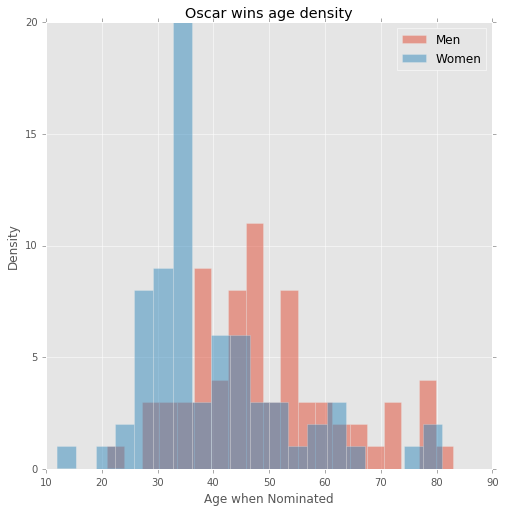

In [19]:
men = nomination_ages(awards=[award.best_actor, award.support_actor], kinds=['W'])
women = nomination_ages(awards=[award.best_actress, award.support_actress], kinds=['W'])
plt.figure(figsize=(8, 8))
plt.hist(men, label='Men', bins=20, alpha=0.5)
plt.hist(women, label='Women', bins=20, alpha=0.5)
plt.xlabel('Age when Nominated')
plt.ylabel('Density')
plt.title('Oscar wins age density')
plt.legend();

This is much more drastic. If you are a woman above 45, your chances of winning an Oscar are very slim (less than 30% of female Oscar winners are above the age of 45). For men, the distribution of ages is much more uniform from the age of 30 onwards.

Clearly, the academy members show age bias towards women, which is not there towards men.

# Compensation

Another common assumption is that winning (or being nominated to) an Oscar bumps up actors' salaries.  Alas, we do not have any access to the financial statements of each and every actor, so we will have to use a proxy; namely, when an actor stars in a movie, the actor's salary is closely correlated with the movie's budget, e.g., in theory the higher the production budget, the higher the above the line budget and therefore the higher the actor's salary (minus, of course, equity/points acquired in the movie).

So, how does getting nominated affects the budgets of the movies an actor performs in? To illustrate the data, for every year $t$ before and after being nominated, we find the median budget for all movies in which a starring actor was first nominated $t$ year ago (or in $t$ years).

In [24]:
def career_data(award_kinds=[award.best_actor, award.support_actor], target='budget', range=(-10, 10), role='actor', group=True):
    noms = nominations.query('award in ' + str(award_kinds))
    first_nom_years = noms.groupby('talentid').min()
    data = []
    for row in first_nom_years.itertuples():
        talentid = row.Index
        first_nom_year = row.year
        talent_movies = roles.query('talentid == "{}" and role == "{}"'.format(talentid, role))['imdbid']
        talent_movies = movies[movies.imdbid.isin(talent_movies)].copy()
        talent_movies['target'] = talent_movies.eval(target)
        talent_movies['diff'] = talent_movies.eval('year - {}'.format(first_nom_year))
        data.append(talent_movies[['diff', 'target']])
        
    data = pd.concat(data)
    data = data.query('diff >= {} and diff <= {}'.format(*range))
    if not group:
        return data
    data = data.groupby('diff').median()
    return data.rolling(center=False,window=2,axis=0, win_type='triang').mean()
    
    

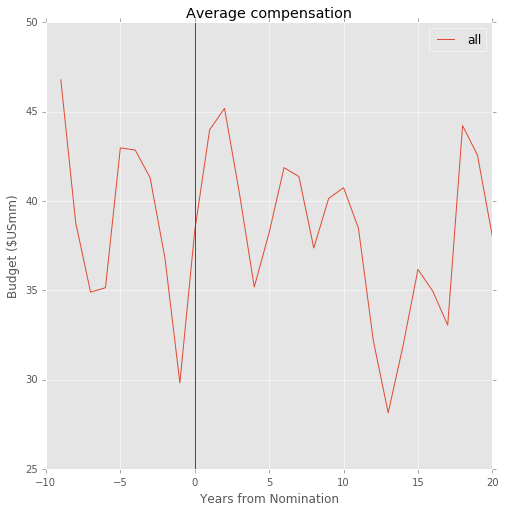

In [30]:
all = career_data(award_kinds=award.acting, target='budget', range=(-10, 20))
plt.figure(figsize=(8, 8))
plt.plot(all.index, all.target, label='all')
plt.xlabel('Years from Nomination')
plt.ylabel('Budget ($USmm)')
plt.title('Average compensation')
plt.axvline(linewidth=1, color='g', x=0)
plt.legend();

Nothing definite here. A slight bump after being nominated. Let us look at the movies' gross:

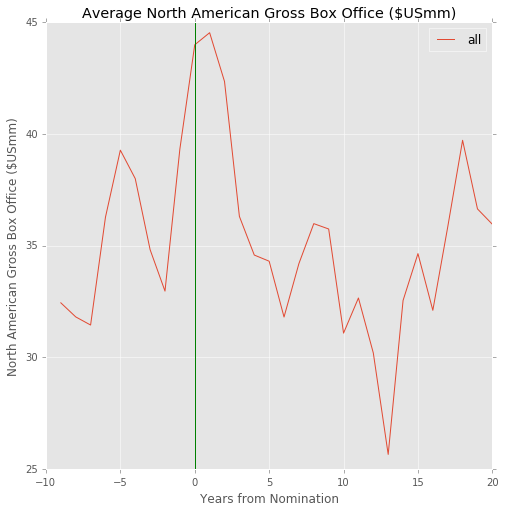

In [176]:
all = career_data(award_kinds=award.acting, target='gross_usa', range=(-10, 20))
plt.figure(figsize=(8, 8))
plt.plot(all.index, all.target, label='all')
plt.xlabel('Years from Nomination')
plt.ylabel('North American Gross Box Office ($USmm)')
plt.title('Average North American Gross Box Office ($USmm)')
plt.axvline(linewidth=1, color='g', x=0)
plt.legend();

This is getting interesting! As we can see, there is a sharp rise in the movies' gross income in the years right after the actors' nomination. However, this rise quickly turns into a sharp fall, and the statistics return to the years before the nomination. 

To further investigate the data, let us check if there is a difference between men and women:

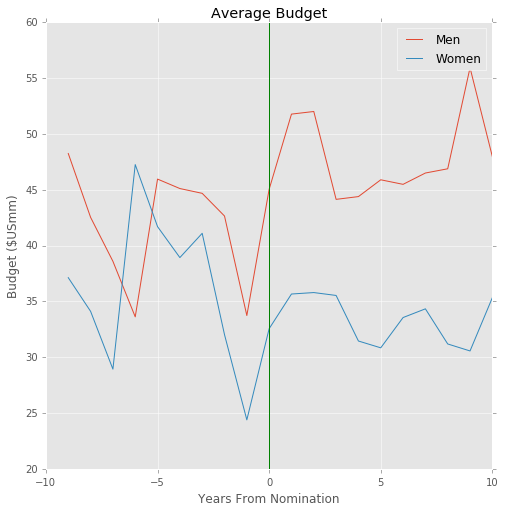

In [25]:
men = career_data(award_kinds=[award.best_actor, award.support_actor], target='budget')
women = career_data(award_kinds=[award.best_actress, award.support_actress], target='budget')

plt.figure(figsize=(8, 8))
plt.plot(men.index, men.target, label='Men')
plt.plot(women.index, women.target, label='Women')
plt.xlabel('Years From Nomination')
plt.ylabel('Budget ($USmm)')
plt.title('Average Budget')
plt.axvline(linewidth=1, color='g', x=0)
plt.legend();

Clearly, men benefit greatly from being nominated - men's average budget rises from around \$40mm to \$50mm - while there is almost no effect on women. Moreover, this graph clearly depicts the compensation disparity between men and women - there is a difference of \$15mm in their movies' aveage budget. This is more clearly portrayed in the following graph:

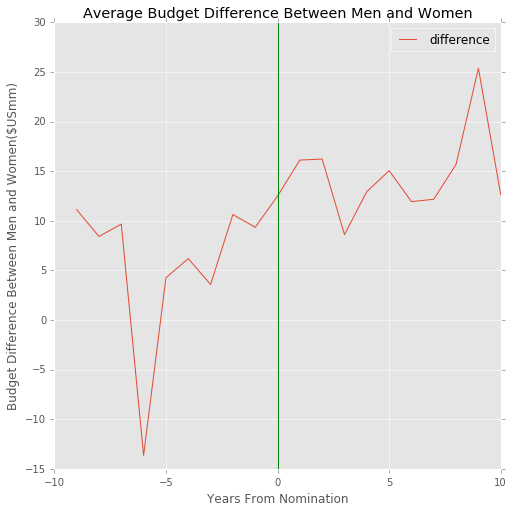

In [27]:
diff = men - women
plt.figure(figsize=(8, 8))
plt.plot(diff.index, diff.target, label='difference')
plt.xlabel('Years From Nomination')
plt.ylabel('Budget Difference Between Men and Women($USmm)')
plt.title('Average Budget Difference Between Men and Women')
plt.axvline(linewidth=1, color='g', x=0)
plt.legend();

Now, what about the gross?

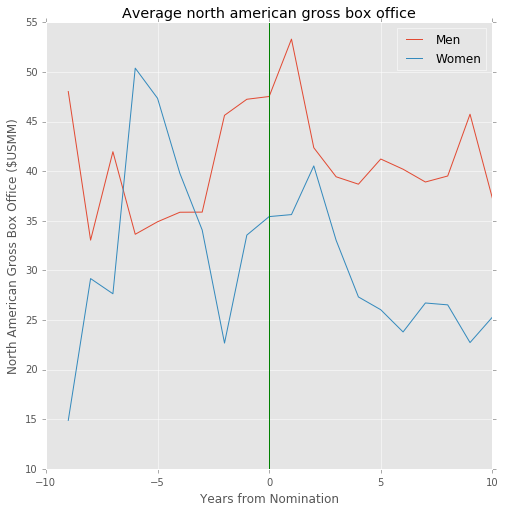

In [174]:
men = career_data(award_kinds=[award.best_actor, award.support_actor], target='gross_usa')
women = career_data(award_kinds=[award.best_actress, award.support_actress], target='gross_usa')

plt.figure(figsize=(8, 8))
plt.plot(men.index, men.target, label='Men')
plt.plot(women.index, women.target, label='Women')
plt.xlabel('Years from Nomination')
plt.ylabel('North American Gross Box Office ($USMM)')
plt.title('Average north american gross box office')
plt.axvline(linewidth=1, color='g', x=0)
plt.legend();

Again, men get a much noticalbe bump in their movies' gross income after being nominated. Moreover, there is also a sharp decline for women 3 years after being nominated, while men's gross returns to its average from before being nominated. 

What would happen if we do not limit ourselves to the first nomination? Let us look at each nomination as a single event, and inspect the average career in light of every nomination. We start with budgets:

In [29]:
def all_career_data(award_kinds=award.acting, target='budget', range=(-10, 10), role='actor'):
    noms = nominations.query('award in ' + str(award_kinds))
    data = []
    for row in noms.itertuples():
        talentid = row.talentid
        year = row.year
        talent_movies = roles.query('talentid == "{}" and role == "{}"'.format(talentid, role))['imdbid']
        talent_movies = movies[movies.imdbid.isin(talent_movies)].copy()
        talent_movies['target'] = talent_movies.eval(target)
        talent_movies['diff'] = talent_movies.eval('year - {}'.format(year))
        talent_movies['talentid'] = talentid
        data.append(talent_movies[['diff', 'target', 'talentid']])
        
    data = pd.concat(data)
    data = data.query('diff >= {} and diff <= {}'.format(*range))
    data = data.groupby('diff').median()
    return data

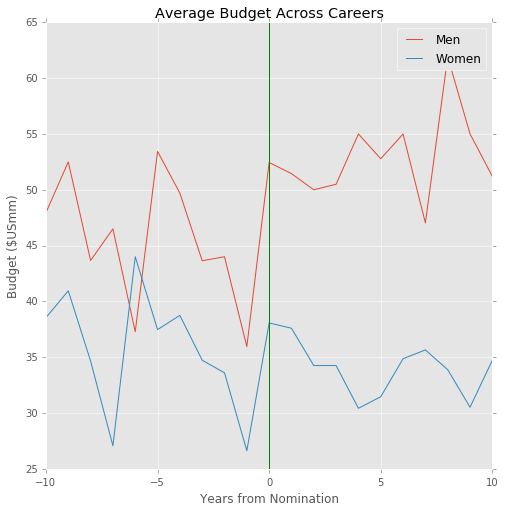

In [30]:
men = all_career_data(award_kinds=[award.best_actor, award.support_actor], target='budget')
women = all_career_data(award_kinds=[award.best_actress, award.support_actress], target='budget')
plt.figure(figsize=(8, 8))
plt.plot(men.index, men.target, label='Men')
plt.plot(women.index, women.target, label='Women')
plt.xlabel('Years from Nomination')
plt.ylabel('Budget ($USmm)')
plt.title('Average Budget Across Careers')
plt.axvline(linewidth=1, color='g', x=0)
plt.legend();

Again, a clear difference between men and women. Moreover, we see that men's compensation picks up significantly after their nomination, while women's career not at all. Lets look at the difference graph as before:

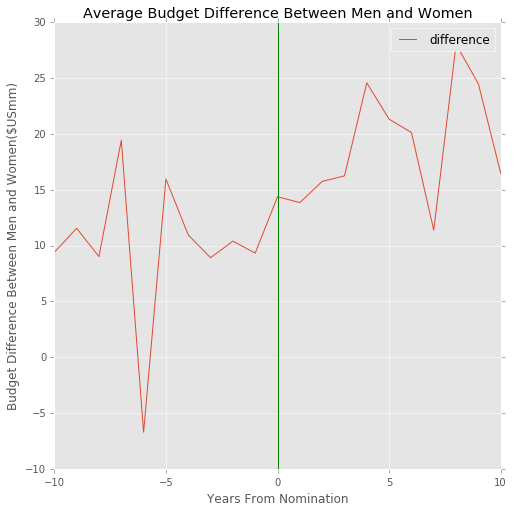

In [31]:
diff = men - women
plt.figure(figsize=(8, 8))
plt.plot(diff.index, diff.target, label='difference')
plt.xlabel('Years From Nomination')
plt.ylabel('Budget Difference Between Men and Women($USmm)')
plt.title('Average Budget Difference Between Men and Women')
plt.axvline(linewidth=1, color='g', x=0)
plt.legend();

This is more pronounced. Almost always men star in higher budget movies, with an upwards trend.

What about the gross?

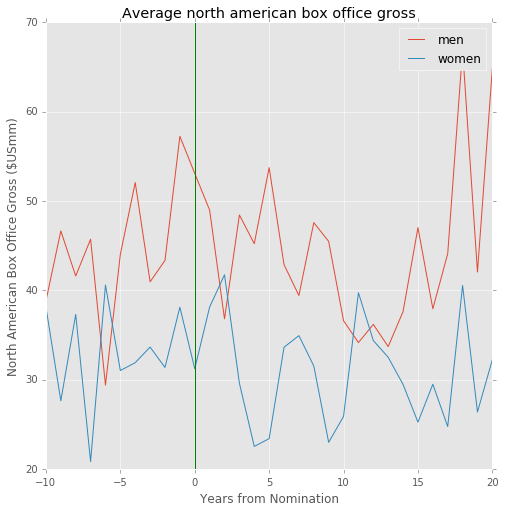

In [29]:
men = all_career_data(award_kinds=[award.best_actor, award.support_actor], target='gross_usa', range=(-10, 20))
women = all_career_data(award_kinds=[award.best_actress, award.support_actress], target='gross_usa', range=(-10, 20))
plt.figure(figsize=(8, 8))
plt.plot(men.index, men.target, label='men')
plt.plot(women.index, women.target, label='women')
plt.xlabel('Years from Nomination')
plt.ylabel('North American Box Office Gross ($USmm)')
plt.title('Average north american box office gross')
plt.axvline(linewidth=1, color='g', x=0)
plt.legend();

Again, women careers get a noticeable boost after being nominated, but dip spectacularly after 5 years. With men the decline takes around 10 years, but ends with a sharp upwards spike.

# Age

What would happen when we pivot the data according to age? We only consider movies in which appeared an actor / actress which were nominated to an Oscar (not necessarily in this same movie). This represents the age related performance of Oscar nominated actors.

In [37]:
def age_data(gender=['M', 'F'], target='budget', role='actor'):
    target_talents = talents[talents.gender.isin(gender)]
    data = []
    for row in target_talents.itertuples():
        talentid = row.talentid
        birth_year = row.birth_date.year
        talent_movies = roles.query('talentid == "{}" and role == "{}"'.format(talentid, role))['imdbid']
        talent_movies = movies[movies.imdbid.isin(talent_movies)].copy()
        talent_movies['target'] = talent_movies.eval(target)
        talent_movies['diff'] = talent_movies.eval('year - {}'.format(birth_year))
        data.append(talent_movies[['diff', 'target']])
        
    data = pd.concat(data)
    # bucket the results
    data['diff'] = data.eval('diff - (diff % 5)')
    grouped = data.groupby('diff')
    data = grouped.median()
    data = data[grouped.count() > 10].fillna(0)
    data = data.query('diff >= 20')
    return data.rolling(center=False,window=2,axis=0, win_type='triang').mean()
    return data

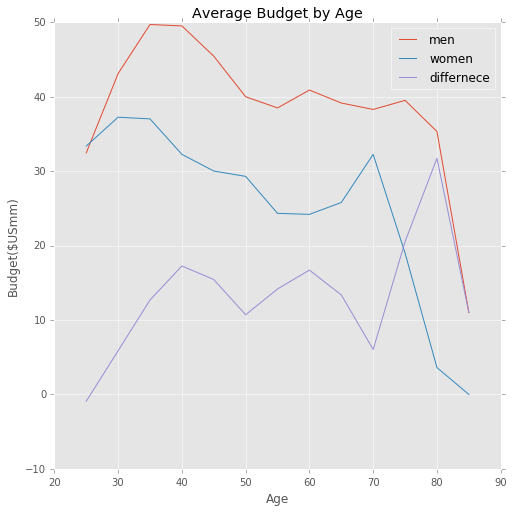

In [38]:
men = np.clip(age_data(gender=['M'], target='budget'), 0, 1.5e8)
women = np.clip(age_data(gender=['F'], target='budget'), 0, 1.5e8)
diff = men - women
plt.figure(figsize=(8, 8))
plt.plot(men.index, men.target, label='men')
plt.plot(women.index, women.target, label='women')
plt.plot(diff.index, diff.target, label='differnece')
plt.xlabel('Age')
plt.ylabel('Budget($USmm)')
plt.title('Average Budget by Age')
plt.legend();

Several things jump out from this:
- The height of men's careers is between the ages of 25 to 45
- The height of women's careers is between the ages of 25 to 35
- Women careers renesans at between the ages of 65 to 70
- The average compensation for women is significantly lower than men

The data reveals that women are paid less, consistently and, moreover, there is a sharp drop when they reach the age of 35. This drop is probably an indication of an age bias with regards to women. 

To complete the picture, let us look at the gross:

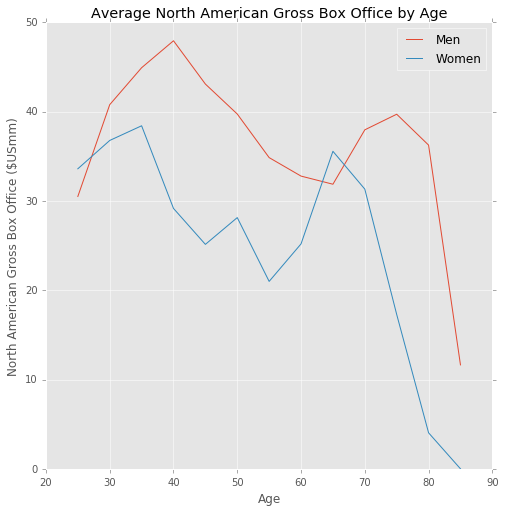

In [39]:
men = np.clip(age_data(gender=['M'], target='gross_usa'), 0, 1.e8)
women = np.clip(age_data(gender=['F'], target='gross_usa'), 0, 1.e8)
plt.figure(figsize=(8, 8))
plt.plot(men.index, men.target, label='Men')
plt.plot(women.index, women.target, label='Women')
plt.xlabel('Age')
plt.ylabel('North American Gross Box Office ($USmm)')
plt.title('Average North American Gross Box Office by Age')
plt.legend();

Up until actors are 30, there is a clear advantage to women. Between 30 and 40 men and women are tied, and we get the same drop in women after the age of 35. However, we have a sharp spike between the ages of 60 and 70, which we could only speculate about its underlying causes.

If we look at the data a bit differently, namely, we normalize the gross of the movies by their budget, we get an interesting picture:

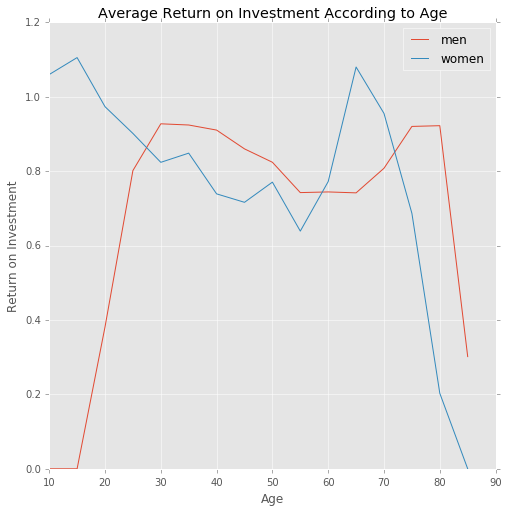

In [23]:
men = age_data(gender=['M'], target='gross_usa/budget')
women = age_data(gender=['F'], target='gross_usa/budget')
plt.figure(figsize=(8, 8))
plt.plot(men.index, men.target, label='men')
plt.plot(women.index, women.target, label='women')
plt.xlabel('Age')
plt.ylabel('Return on Investment')
plt.title('Average Return on Investment According to Age')
plt.legend();

In terms of profitability, women dominate the playing field up until the age of 30. Between 30 and 45 men and women have approximately the same profitability. Between the ages of 45 to 60, men clearly dominate. There is also a spike for women between 60 and 70, but the last interesting bit is that men can resume their career into their 80 and have no adverse effect on their profitability.

# Genres

So far, the data reflects that women participate in lower budgeted movies overall and that men have a greater lifetime earning capacity.  Let’s delve even deeper.  We will now try to characterize genres by gender.

We begin by generating an overview of the average movie budgets and average gross income by genre:

In [50]:
def genres_data(target='budget'):
    targets = movies.merge(genres, on='imdbid')
    targets[target] = targets.eval(target)
    return targets.groupby('genre').median()[target]

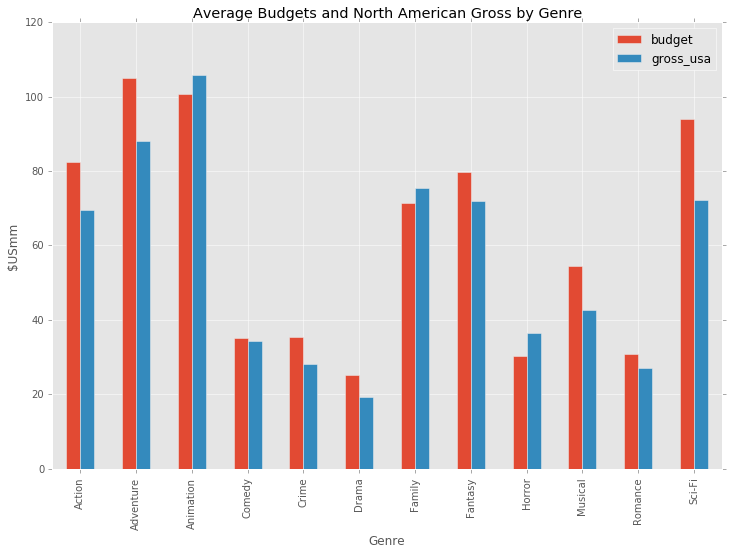

In [144]:
data = pd.concat([genres_data(target='budget'), genres_data(target='gross_usa')], axis=1)
data.plot.bar(figsize=(12, 8))
plt.xlabel('Genre')
plt.ylabel('$USmm')
plt.title('Average Budgets and North American Gross by Genre');


The chart clearly shows that the top 4 grossing (and budgeted) genres are:
- Action
- Adventure
- Animation
- Sci-Fi

To bottom 3 are:
- Drama
- Horror
- Romance

To some that might be obvious, to others not.  
However, let us drop Animation for now, we will come back to it later. Instead, let’s take a closer look at the distribution of genres across actors' careers.  Overall, for both male and female, the data reveals:

In [2]:
def genres_by_age(gender=['M', 'F'], role='actor'):
    target_talents = talents[talents.gender.isin(gender)]
    data = []
    for row in target_talents.itertuples():
        talentid = row.talentid
        birth_year = row.birth_date.year
        talent_movies = roles.query('talentid == "{}" and role == "{}"'.format(talentid, role))[['imdbid']]
        talent_movies = talent_movies.merge(movies, on='imdbid')
        g = talent_movies[['imdbid', 'year']].merge(genres, on='imdbid')
        age = g.year - birth_year
        age = age - (age % 5)
        g['age'] = age
        data.append(g)
        
    
    data = pd.concat(data)
    data = data.groupby(['age', 'genre'])['age'].agg(['count']).unstack('age', fill_value=0)
    return data

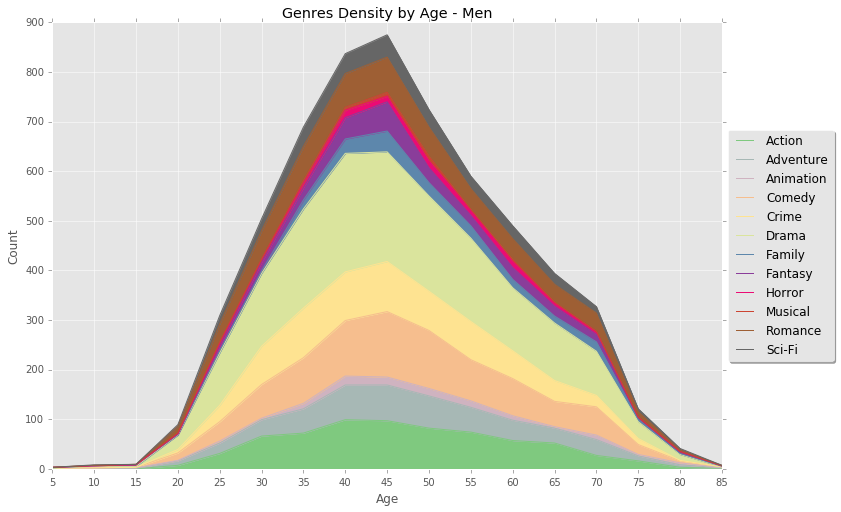

In [95]:
men = genres_by_age(gender=['M'])
men.T.plot.area(figsize=(12, 8), colormap='Accent')
ages = men.T.index.get_level_values(1)
plt.xticks(np.arange(0, len(ages)), [str(x) for x in ages])

plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Genres Density by Age - Men')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fancybox=True, shadow=True);

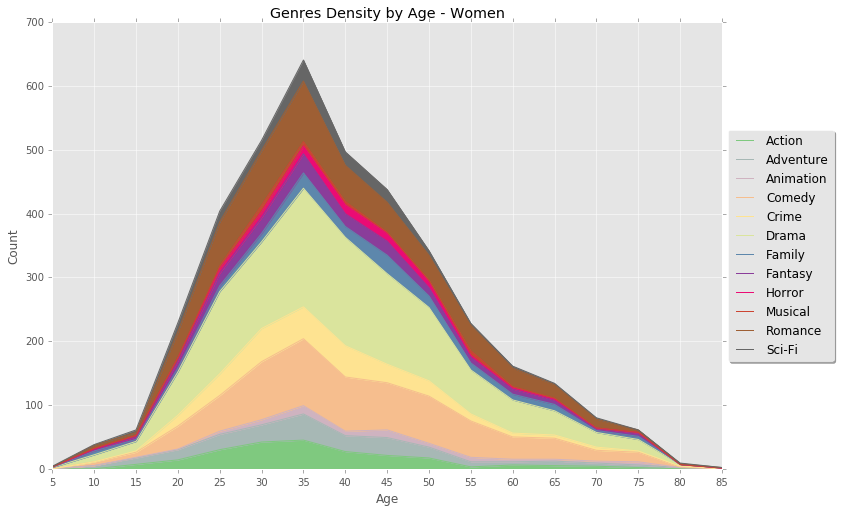

In [96]:
women = genres_by_age(gender=['F'])
women.T.plot.area(figsize=(12, 8), colormap='Accent')

ages = women.T.index.get_level_values(1)
plt.xticks(np.arange(0, len(ages)), [str(x) for x in ages])
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Genres Density by Age - Women')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          ncol=1, fancybox=True, shadow=True);

The following points are pretty much self explenatory:
- Men's careeres peak at age 45 (the largest count of appearences)
- Women's careers peak at age 35
- Action, Comedy and Drama dominate men's careers
- Drama and Romance movies dominate women's careers

Lets look at the top 3 budgeted genres from before:

In [67]:
def genres_by_age_grouped(gender=['M', 'F'], role='actor', group=['Crime']):
    data = genres_by_age(gender=gender, role=role)
    def getter(x):
        if x in group:
            return 'grouped'
        else:
            return 'rest'
    data = data.groupby(getter).sum()
    data[data < 10] = 0
    return data

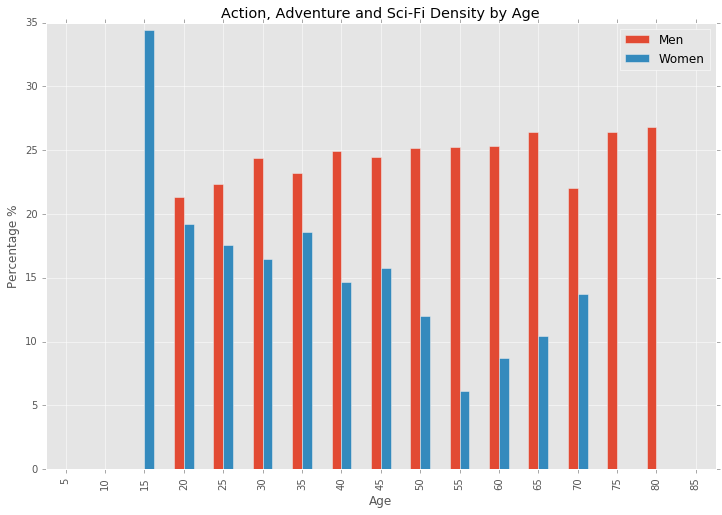

In [98]:
men = genres_by_age_grouped(gender=['M'], group=['Action', 'Adventure', 'Sci-Fi'])
men = men * 100. / men.sum()

women = genres_by_age_grouped(gender=['F'], group=['Action', 'Adventure', 'Sci-Fi'])
women = women * 100. / women.sum()

data = pd.concat([men['count'].loc['grouped'], women['count'].loc['grouped']], axis=1)
data.columns = ['Men', 'Women']
data.plot.bar(figsize=(12,8))
plt.xlabel('Age')
plt.ylabel('Percentage %')
plt.title('Action, Adventure and Sci-Fi Density by Age');

Interesting.  The top 3 budgeted genres are (almost) consistently represented throughout male actors careers and compose around 25% of the movies men participate in. However, with regards to female actresses, we can clearly see there is a dramatic decline starting at age 35.  This decline is closely correlated with the decline in women's compensation that we discovered in the above data. Moreover, the decline corrects itself after the age of 55, but never regains its initial strength.

Yet the question remains; what happens in the bottom 3 budgeted genres?

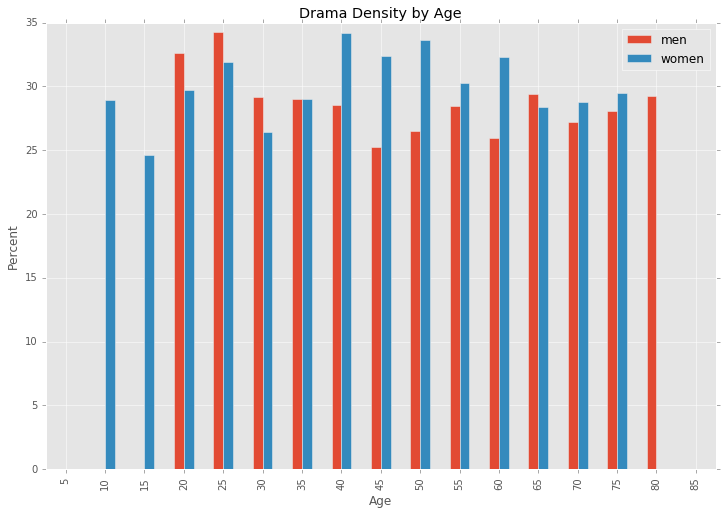

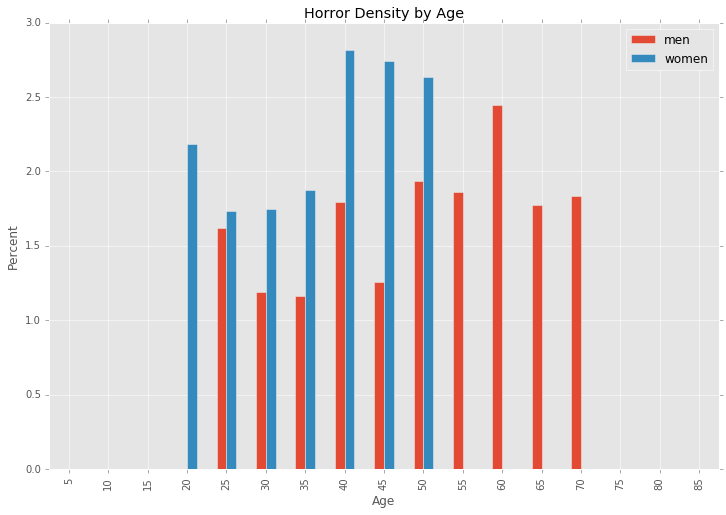

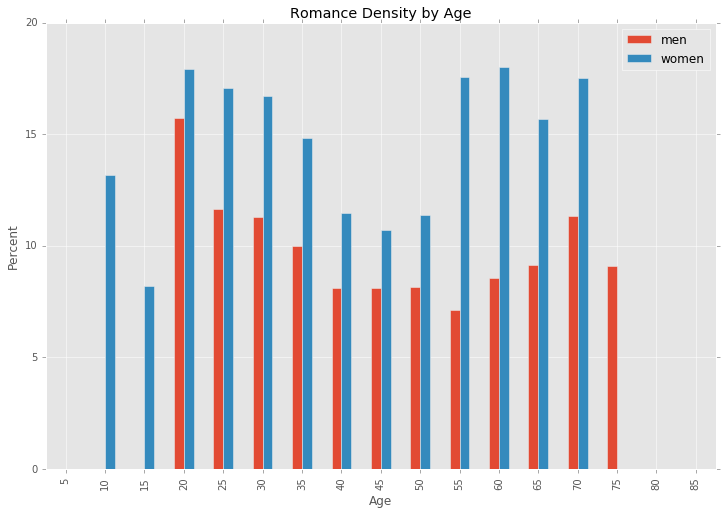

In [173]:
def single_genre_plot(genre='Crime'):
    men = genres_by_age_grouped(gender=['M'], group=[genre])
    men = men * 100. / men.sum()

    women = genres_by_age_grouped(gender=['F'], group=[genre])
    women = women * 100. / women.sum()

    data = pd.concat([men['count'].loc['grouped'], women['count'].loc['grouped']], axis=1)
    data.columns = ['Men', 'Women']
    data.plot.bar(figsize=(12,8))
    plt.xlabel('Age')
    plt.ylabel('Percentage %')
    plt.title(genre + ' Density by Age');
    
for genre in ['Drama', 'Horror', 'Romance']:
    single_genre_plot(genre=genre)

Certainly, these genres play a larger part throughout females actresses careers than males. 

Perhaps the most interesting insight is that that females are not cast to leading roles in romantic movies between the ages of 35 and 55.  

But what about Animation movies? Why have we left them out?

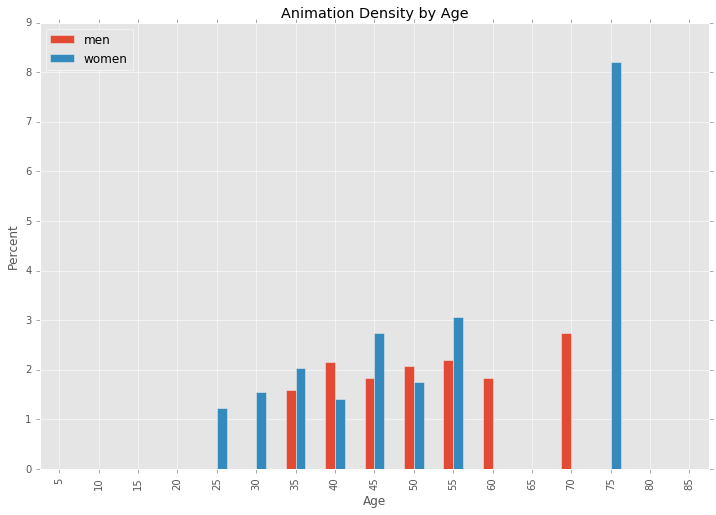

In [172]:
single_genre_plot('Animation');

Surprisingly, animated movies are clearly dominated by actresses.  Moreover, the trend is rising with actresses age, which goes completely against the live-action data.  Could it be said that when it comes simply to voice actresses producers don't mind their age?  Well, that is indeed what the data reflects.

# Netflix

Based on the above findings we decided to look at the original movies that Netflix have and will release through to 2017. As a new-age, data driven movie studio, it was interesting to analyze if Netflix have broken the mould or analyzed and predicted that audiences are sexist and ageist.  

- 66% (10 out of the 15 movies) do not feature a top billed actress above 35.
- 50% (7 out of 15 movies) only feature males in the top billing.
- 0% (15 out of 15 movies) do not feature only females in their top billing.
- Out of the 75 top billed actors across the 15 movies:
    - 80% are male
    - 5% are females under 35
    - 15% are females above 35

Whilst Netflix do not discriminate as significantly against over 35 female actors as their less-data driven counterparts, it is clear that their original movie strategy is male dominated, which by definition pays more to males.

# Conclusions

Well, it’s true: actresses do get a raw deal when it comes to audience, producers, heck even the financers.  Indeed, females do tend to be nominated for Oscars when they are younger than their male counterparts.  However, this trade off comes in the way of ageism.  Put simply, men are hired more consistently throughout the careers, whilst woman completely drop away after 35.  Even more troubling is that after the age of 45 it’s almost impossible for females to win an Oscar.  This sustainability issue further relates to the top 3 grossing and budgeted genres, where men are able to enjoy, in theory, larger pay packets, whilst women dominate the 3 bottom grossing and budgeted genres, enjoying, in theory, less pay.

Whilst it is now clear as day that woman get the short end of the stick, both men and women succeed in obtaining a short term boost to their career earnings after an Oscar nomination.  But this short term win, becomes a long term drop.  Could that coveted Oscar nomination be the kiss of death?  Whether yes or no, the data clearly shows that males will still have consistent earnings over their career, compared to actresses whose careers clearly fall off a cliff after 35. 

But from what we see from all the data presented is that female actors do have a way out.  An extremely sexist and ageist way out: voice over for animated movies… for the rest of their careers… if they want to work.  Whilst animation is certainly a creative and popular area of entertainment, we can say (with no data to back up our claims), actresses still want the opportunity to work in live action movies after they get a wrinkle or two, just like their male counterparts.
